# 🌲 Forêts Aléatoires (Random Forest) from Scratch

La forêt aléatoire (Random Forest) est un algorithme d’apprentissage supervisé utilisé pour les tâches de classification et de régression. Elle repose sur le principe de l’agrégation de plusieurs arbres de décision afin d’améliorer la performance globale du modèle tout en réduisant le risque de surapprentissage (overfitting).

# Origine

Proposée par Tin Kam Ho en 1995 comme méthode d’agrégation d’arbres.

Popularisée par Leo Breiman et Adele Cutler en 2001.

Elle s’appuie sur deux techniques clés :

- Bagging (Bootstrap Aggregating)

- Sélection aléatoire de sous-ensembles de variables à chaque nœud de décision.

# Principe de fonctionnement

Une forêt aléatoire construit plusieurs arbres de décision sur des sous-échantillons différents du jeu de données. Chaque arbre donne une prédiction :

- En classification : le vote majoritaire est retenu.

- En régression : la moyenne des prédictions est utilisée.

# Formule mathématique simplifiée

Soient M arbres T₁(x), T₂(x), ..., Tₘ(x) :

- Classification :
ŷ = mode{T₁(x), T₂(x), ..., Tₘ(x)}

- Régression :
ŷ = (1/M) ∑_{i=1}^M Tᵢ(x)

Chaque Tᵢ est construit avec :

- un bootstrap du dataset d’origine

- un sous-ensemble aléatoire de variables à chaque split

# Avantages

- ✅ Robuste au surapprentissage (overfitting)
- ✅ Précis même avec des données bruitées
- ✅ Fonctionne bien avec de nombreuses variables
- ✅ Gère naturellement les données manquantes
- ✅ Donne l’importance des variables

# Inconvénients

- ❌ Moins interprétable qu’un seul arbre de décision
- ❌ Plus lent à entraîner et prédire (surtout avec beaucoup d’arbres)
- ❌ Peut nécessiter des réglages de paramètres pour être optimal
- ❌ Occupation mémoire élevée

# Cas d’usage

- Diagnostic médical

- Détection de fraude

- Classification d’images

- Prédiction de prix (immobilier, marché)

In [24]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [25]:
class NoeudDecision:
    def __init__(self, feature_index=None, seuil=None, gauche=None, droite=None, valeur=None):
        self.feature_index = feature_index  # index de la variable utilisée pour le split
        self.seuil = seuil  # seuil de découpe
        self.gauche = gauche  # sous-arbre gauche
        self.droite = droite  # sous-arbre droit
        self.valeur = valeur  # valeur prédite (si nœud terminal)

class ArbreDecision:
    def __init__(self, max_profondeur=5, min_echantillons_split=2, tache='classification', importance_dict=None):
        self.max_profondeur = max_profondeur  # profondeur max de l’arbre
        self.min_echantillons_split = min_echantillons_split  # taille min pour split
        self.racine = None  # racine de l’arbre
        self.tache = tache  # 'classification' ou 'regression'
        self.importance_dict = importance_dict if importance_dict is not None else defaultdict(int)  # importance des variables

    # mesure l'hétérogénéité
    def _impurete(self, y):
        if self.tache == 'classification':
            freqs = np.bincount(y) / len(y)  # distribution des classes
            return 1.0 - np.sum(freqs**2)  # impureté de Gini
        else:
            return np.var(y)  # variance (régression)

    #  cherche la variable et le seuil optimaux
    def _meilleur_split(self, X, y):
        best_gain = -1
        best_idx, best_seuil = None, None
        n_features = X.shape[1]

        for feature_index in range(n_features):
            seuils = np.unique(X[:, feature_index])
            for seuil in seuils:
                gauche_idx = X[:, feature_index] <= seuil
                droite_idx = X[:, feature_index] > seuil
                if len(y[gauche_idx]) == 0 or len(y[droite_idx]) == 0:
                    continue
                gain = self._gain(y, y[gauche_idx], y[droite_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_idx = feature_index
                    best_seuil = seuil
        return best_idx, best_seuil

    # évalue la qualité d’un split
    def _gain(self, y, y_gauche, y_droite):
        impurete_init = self._impurete(y)
        impurete_g = self._impurete(y_gauche)
        impurete_d = self._impurete(y_droite)
        poids_g = len(y_gauche) / len(y)
        poids_d = len(y_droite) / len(y)
        return impurete_init - (poids_g * impurete_g + poids_d * impurete_d)
    
    #  construit l’arbre récursivement
    def _construire(self, X, y, profondeur):
        if len(set(y)) == 1 or profondeur >= self.max_profondeur or len(y) < self.min_echantillons_split:
            valeur = np.mean(y) if self.tache == 'regression' else Counter(y).most_common(1)[0][0]
            return NoeudDecision(valeur=valeur)

        idx, seuil = self._meilleur_split(X, y)
        if idx is None:
            valeur = np.mean(y) if self.tache == 'regression' else Counter(y).most_common(1)[0][0]
            return NoeudDecision(valeur=valeur)

        self.importance_dict[idx] += 1

        gauche_idx = X[:, idx] <= seuil
        droite_idx = X[:, idx] > seuil
        gauche = self._construire(X[gauche_idx], y[gauche_idx], profondeur + 1)
        droite = self._construire(X[droite_idx], y[droite_idx], profondeur + 1)
        return NoeudDecision(feature_index=idx, seuil=seuil, gauche=gauche, droite=droite)

    # entraîner l’arbre
    def fit(self, X, y):
        self.racine = self._construire(X, y, 0)

    def _predire(self, x, noeud):
        if noeud.valeur is not None:
            return noeud.valeur
        if x[noeud.feature_index] <= noeud.seuil:
            return self._predire(x, noeud.gauche)
        else:
            return self._predire(x, noeud.droite)
    # prédit pour chaque observation
    def predict(self, X):
        return np.array([self._predire(x, self.racine) for x in X])


In [26]:

class ForetAleatoire:
    def __init__(self, n_estimateurs=10, max_profondeur=5, tache='classification'):
        self.n_estimateurs = n_estimateurs         # nombre d’arbres à entraîner
        self.max_profondeur = max_profondeur       # profondeur max pour chaque arbre
        self.tache = tache                          # 'classification' ou 'regression'
        self.arbres = []                            # liste pour stocker les arbres entraînés
        self.importance_globale = defaultdict(int)  # importance des variables (globalement)

    def fit(self, X, y):
        self.arbres = []
        for _ in range(self.n_estimateurs):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            importance_dict = defaultdict(int)
            arbre = ArbreDecision(max_profondeur=self.max_profondeur, tache=self.tache, importance_dict=importance_dict)
            arbre.fit(X_sample, y_sample)
            for k, v in importance_dict.items():
                self.importance_globale[k] += v
            self.arbres.append(arbre)

    def predict(self, X):
        predictions = np.array([arbre.predict(X) for arbre in self.arbres])
        if self.tache == 'classification':
            return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        else:
            return np.mean(predictions, axis=0)

def evaluation_classification(y_true, y_pred, y_proba=None):
    print("Accuracy :", np.mean(y_true == y_pred))
    print(classification_report(y_true, y_pred))
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        print("AUC :", auc)
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("Faux positifs")
        plt.ylabel("Vrais positifs")
        plt.title("Courbe ROC")
        plt.legend()
        plt.grid(True)
        plt.show()

def evaluation_regression(y_true, y_pred):
    print("R² :", r2_score(y_true, y_pred))
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("MSE :", mean_squared_error(y_true, y_pred))






--- Évaluation Forêt Aléatoire (Titanic) ---
Accuracy : 0.7622377622377622
              precision    recall  f1-score   support

           0       0.77      0.86      0.82        87
           1       0.74      0.61      0.67        56

    accuracy                           0.76       143
   macro avg       0.76      0.73      0.74       143
weighted avg       0.76      0.76      0.76       143

AUC : 0.8117816091954023


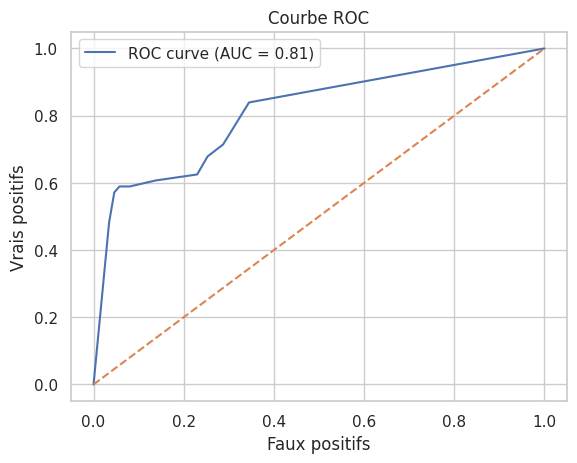


--- Importance des variables (ordre décroissant) ---
Age : 87
Fare : 80
Pclass : 37
Sex : 10


In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df = df[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
X = df.drop('Survived', axis=1).values
y = df['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

foret = ForetAleatoire(n_estimateurs=10, max_profondeur=5, tache='classification')
foret.fit(X_train, y_train)
y_pred = foret.predict(X_test)

def probabilites_foret(foret, X):
    predictions = np.array([arbre.predict(X) for arbre in foret.arbres])
    return np.mean(predictions, axis=0)

y_proba = probabilites_foret(foret, X_test)

print("\n--- Évaluation Forêt Aléatoire (Titanic) ---")
evaluation_classification(y_test, y_pred, y_proba)

noms_features = df.drop('Survived', axis=1).columns
importances = dict(sorted(foret.importance_globale.items(), key=lambda item: item[1], reverse=True))
print("\n--- Importance des variables (ordre décroissant) ---")
for idx, score in importances.items():
    print(f"{noms_features[idx]} : {score}")

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df = df[['Pclass', 'Sex', 'Age', 'Fare']].dropna()
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
X = df.drop('Fare', axis=1).values
y = df['Fare'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Entraînement ===
foret = ForetAleatoire(n_estimateurs=10, max_profondeur=5, tache='regression')
foret.fit(X_train, y_train)
y_pred = foret.predict(X_test)

# === Évaluation ===
print("\n--- Évaluation Forêt Aléatoire (Régression - Titanic) ---")
evaluation_regression(y_test, y_pred)

# === Importance des variables ===
noms_features = df.drop('Fare', axis=1).columns
importances = dict(sorted(foret.importance_globale.items(), key=lambda item: item[1], reverse=True))
print("\n--- Importance des variables (ordre décroissant) ---")
for idx, score in importances.items():
    print(f"{noms_features[idx]} : {score}")
    




--- Évaluation Forêt Aléatoire (Régression - Titanic) ---
R² : 0.1380618549031858
MAE : 21.441204428541187
MSE : 3588.4976865152844

--- Importance des variables (ordre décroissant) ---
Age : 223
Sex : 49
Pclass : 21
